# ResNet18 Training of Unbalanced DeepInsight Data
**Author:** Puxin
 
**Latest version:** 2024-12-01

In [1]:
import torch

**Usage of GPU**

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Reproducibility**

In [3]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import random
import numpy as np

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  

set_seed(2024)

**Original input image**

In [5]:
from PIL import Image

# Load an image
image = Image.open("/kaggle/input/deepinsight-unbalanced/Unbalanced/malign/sample1.png")

# Check the image mode
print("Image mode:", image.mode)

Image mode: I;16


**Load images**

In [ ]:
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader

In [7]:
# Define preprocessing pipeline for the image
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [8]:
dataset_path = "/kaggle/input/deepinsight-unbalanced/Unbalanced"
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

In [9]:
# Get a dictionary associating the class index with the class name
target_to_class = {v: k for k, v in dataset.class_to_idx.items()}
print(target_to_class)

{0: 'benign', 1: 'malign'}


In [ ]:
from collections import Counter

labels = dataset.targets

label_counts = Counter(labels)

# Print the counts for each label
print(f"Classes: {dataset.classes}")
for label, count in label_counts.items():
    class_name = dataset.classes[label]  
    print(f"Class: {class_name}, Count: {count}")

Classes: ['benign', 'malign']
Class: benign, Count: 3000
Class: malign, Count: 1465


**Split the data: stratified split**

In [11]:
from sklearn.model_selection import train_test_split

labels = dataset.targets

train_idx, test_idx = train_test_split(
    np.arange(len(labels)),
    test_size=0.2,
    random_state=2024,
    shuffle=True,
    stratify=labels)

In [12]:
print(f"Training set count: {len(train_idx)}")
print(f"test set count: {len(test_idx)}")

Training set count: 3572
test set count: 893


In [13]:
from torch.utils.data import Subset

# Subset dataset for train and test
train_dataset = Subset(dataset, train_idx)
test_dataset= Subset(dataset, test_idx)

# Dataloader for train and test
train_loader = DataLoader(train_dataset, batch_size=37, shuffle=False) 
test_loader = DataLoader(test_dataset, batch_size=37, shuffle=False)

In [ ]:
for images, labels in train_loader:
    print(f"Images batch shape: {images.shape}")  
    print(f"Labels batch: {labels}")
    break

Images batch shape: torch.Size([37, 3, 224, 224])
Labels batch: tensor([0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0])


In [15]:
for images, labels in test_loader:
    print(f"Images batch shape: {images.shape}")  
    print(f"Labels batch: {labels}")
    break

Images batch shape: torch.Size([37, 3, 224, 224])
Labels batch: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0])


**ResNet18**

In [16]:
import torchvision.models as models

In [17]:
model = models.resnet18(weights=None)

# Modify the final fully connected layer
model.fc = nn.Linear(model.fc.in_features, 1)

# Print the modified fc layer
print(model.fc)

Linear(in_features=512, out_features=1, bias=True)


In [18]:
#loss
loss_fn = nn.BCEWithLogitsLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1.1924159908509038e-05, weight_decay=0.010242202281967362) 

In [19]:
def test_phase(model, test_loader):
    model.eval()  
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():  
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            logits = model(images)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).long().squeeze(1)
            test_correct += (preds == labels).sum().item()
            
            loss = loss_fn(logits, labels.unsqueeze(1).float())
            test_loss += loss.item() * labels.size(0)
    
    # Compute average test loss and accuracy
    avg_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = test_correct / len(test_loader.dataset)
    return avg_test_loss, test_accuracy

In [20]:
num_epochs = 100
torch.manual_seed(2024)
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
model.to(device)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    train_correct = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, labels.unsqueeze(1).float())
        
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).long().squeeze(1)
        train_correct += (preds == labels).sum().item()
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * labels.size(0)

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    # Test phase
    test_result = test_phase(model, test_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.2f}, Test Loss: {test_result[0]:.2f}, Train Accuracy: {train_accuracy:.2f}, Test Accuracy: {test_result[1]:.2f}")
    train_losses.append(avg_train_loss)
    test_losses.append(test_result[0])
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_result[1])
    
    if test_result[0] < 0.2 or test_result[1] > 0.87:
        torch.save(model.state_dict(), f"ResNet18_DI_ub_epoch{epoch+1}.pth")
        torch.save(model.state_dict(), f"ResNet18_DI_ub_epoch{epoch+1}.pt")

Epoch 1/100, Train Loss: 0.49, Test Loss: 0.56, Train Accuracy: 0.79, Test Accuracy: 0.74
Epoch 2/100, Train Loss: 0.35, Test Loss: 0.39, Train Accuracy: 0.87, Test Accuracy: 0.84
Epoch 3/100, Train Loss: 0.29, Test Loss: 0.50, Train Accuracy: 0.89, Test Accuracy: 0.80
Epoch 4/100, Train Loss: 0.25, Test Loss: 0.45, Train Accuracy: 0.91, Test Accuracy: 0.81
Epoch 5/100, Train Loss: 0.22, Test Loss: 0.35, Train Accuracy: 0.92, Test Accuracy: 0.89
Epoch 6/100, Train Loss: 0.19, Test Loss: 1.22, Train Accuracy: 0.93, Test Accuracy: 0.43
Epoch 7/100, Train Loss: 0.16, Test Loss: 3.38, Train Accuracy: 0.94, Test Accuracy: 0.39
Epoch 8/100, Train Loss: 0.14, Test Loss: 4.89, Train Accuracy: 0.96, Test Accuracy: 0.38
Epoch 9/100, Train Loss: 0.12, Test Loss: 4.80, Train Accuracy: 0.96, Test Accuracy: 0.38
Epoch 10/100, Train Loss: 0.11, Test Loss: 0.79, Train Accuracy: 0.97, Test Accuracy: 0.57
Epoch 11/100, Train Loss: 0.10, Test Loss: 5.01, Train Accuracy: 0.97, Test Accuracy: 0.40
Epoch 12

**Learning Curve**

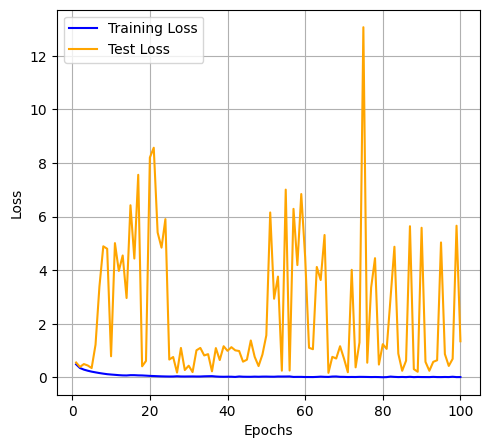

In [ ]:
import matplotlib.pyplot as plt

# Plotting the loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

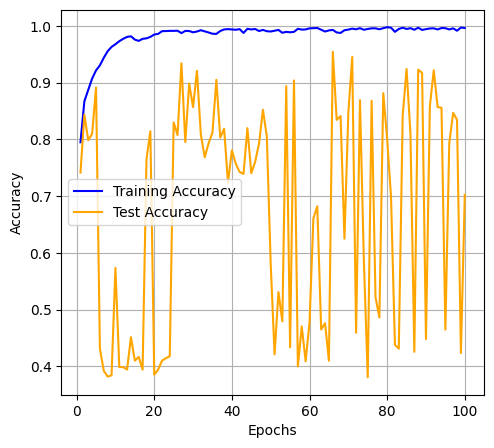

In [ ]:
# Plotting the accuracy curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()